# Hashing Using a Binary Autoencoder

In [ ]:
# Train an autoencoder where the encoder has a 16-neuron output layer, using the sigmoid activation function, 
# and heavy Gaussian noise just before it. During training, the noise layer will encourage the previous layer 
# to learn to output large values, since small values will just be crushed by the noise. In turn, this means 
# that the output layer will output values close to 0 or 1, thanks to the sigmoid activation function. Once we 
# round the output values to 0s and 1s, we get a 16-bit "semantic" hash. If everything works well, images that 
# look alike will have the same hash. This can be very useful for search engines: for example, if we store each 
# image on a server identified by the image's semantic hash, then all similar images will end up on the same 
# server. Users of the search engine can then provide an image to search for, and the search engine will compute 
# the image's hash using the encoder, and quickly return all the images on the server identified by that hash.

In [1]:
# Setup imports:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [3]:
# Using Fashion-MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [4]:
# utility metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [7]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [10]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [16]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [14]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

In [5]:
tf.random.set_seed(42)
np.random.seed(42)

hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[16]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5250 - rounded_accuracy: 0.7116 - val_loss: 0.4856 - val_rounded_accuracy: 0.7350
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4838 - rounded_accuracy: 0.7378 - val_loss: 0.4690 - val_rounded_accuracy: 0.7648
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4371 - rounded_accuracy: 0.7906 - val_loss: 0.4216 - val_rounded_accuracy: 0.8033
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4115 - rounded_accuracy: 0.8120 - val_loss: 0.4166 - val_rounded_accuracy: 0.8044
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4032 - rounded_accuracy: 0.8180 - val_loss: 0.4105 - val_rounded_accuracy: 0.8096
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4000 - rounded_accuracy: 0.8209 - val_loss: 0.4113 - val_rounded_accuracy: 0.8103
Epoch 7/10
1719/1719 [==================

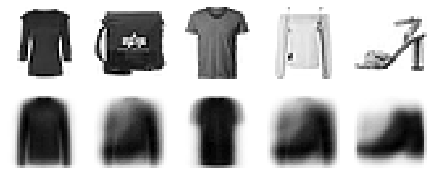

In [11]:
show_reconstructions(hashing_ae)
plt.show()

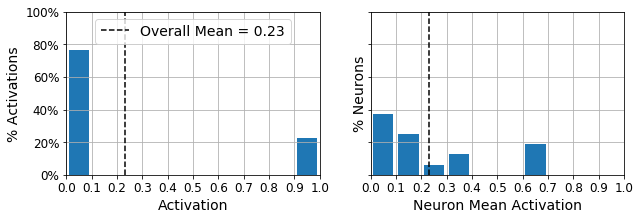

In [17]:
plot_activations_histogram(hashing_encoder)
plt.show()

In [20]:
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

0100000000001001
0000000000001000
0101000100001001
0000000000000000
0000010000000000
...


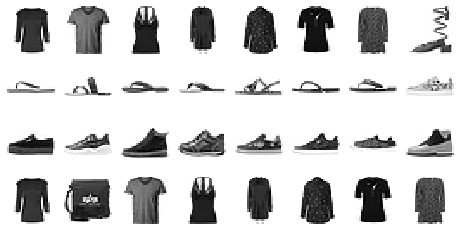

In [21]:
n_bits = 4
n_images = 8
plt.figure(figsize=(n_images, n_bits))
for bit_index in range(n_bits):
    in_bucket = (hashes & 2**bit_index != 0)
    for index, image in zip(range(n_images), X_valid[in_bucket]):
        plt.subplot(n_bits, n_images, bit_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")